# 3D GAUSSIAN SPLATTING

## Introduction
 3D Gaussian Splatting is a recent technique for novel view synthesis that achieves real-time rendering with state-of-the-art quality​. It replaces expensive neural networks with a fast point-based representation: the scene is represented as millions of tiny 3D Gaussians (“splats”), each with a position, anisotropic covariance (shape), color (with view-dependent effects), and opacity.

The method has three key components​: 
1. starting from a sparse set of points (e.g. from COLMAP Structure-from-Motion), initialize a radiance field as 3D Gaussians instead of voxels or meshes; 
2. interleave optimization of Gaussian parameters (position, covariance, color) with adaptive density control (adding or removing Gaussians) to progressively refine scene geometry; 
3. use a fast differentiable rasterizer that projects these 3D Gaussians to the image plane and blends them with proper ordering (front-to-back alpha compositing) for real-time rendering​. 


We will reimplement the core of this pipeline step by step in Python/PyTorch, explaining each part in detail and linking to the corresponding parts of the paper.

## Data Processing (Input Preparation)

The first step is to prepare the input data: a set of calibrated images of the scene and an initial sparse 3D point cloud (if available). The sparse points typically come from a Structure-from-Motion (SfM) reconstruction (e.g. COLMAP) of the scene. These SfM points will serve as initial Gaussian locations, providing a rough geometry prior for optimization​. If an initial point cloud is not available (e.g. for synthetic scenes), we can start with a random distribution of points, but using real SfM points speeds up convergence and improves quality.

In [1]:
# First lets get COLMAP's read/write python utilities

!wget https://raw.githubusercontent.com/colmap/colmap/dev/scripts/python/read_write_model.py


--2025-03-02 16:51:24--  https://raw.githubusercontent.com/colmap/colmap/dev/scripts/python/read_write_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22534 (22K) [text/plain]
Saving to: ‘read_write_model.py.2’

read_write_model.py 100%[===================>]  22,01K  --.-KB/s    in 0,002s  

2025-03-02 16:51:24 (11,9 MB/s) - ‘read_write_model.py.2’ saved [22534/22534]



Points: (206613, 3)
Num images loaded: 292
Camera poses: 292
Camera intrinsics: 292
Image files: 292
Images loaded: 292


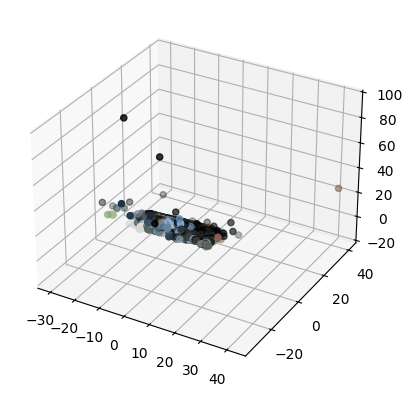

In [2]:
import os
import numpy as np
import cv2
import read_write_model  # from colmap scripts

def load_mipnerf_scene(scene_path, resolution_folder="images_8"):
    sparse_path = os.path.join(scene_path, "sparse", "0")
    cameras_bin = os.path.join(sparse_path, "cameras.bin")
    images_bin  = os.path.join(sparse_path, "images.bin")
    points3d_bin= os.path.join(sparse_path, "points3D.bin")
    
    # Read colmap binaries
    cameras_dict = read_write_model.read_cameras_binary(cameras_bin)
    images_dict  = read_write_model.read_images_binary(images_bin)
    points3D_dict= read_write_model.read_points3D_binary(points3d_bin)
    
    # Convert points
    points_world = []
    points_color = []
    for pid, p3d_data in points3D_dict.items():
        points_world.append(p3d_data.xyz)
        points_color.append(p3d_data.rgb)
    points_world = np.array(points_world, dtype=np.float32)
    points_color = np.array(points_color, dtype=np.uint8)
    
    # Prepare lists for camera extrinsics & intrinsics
    camera_poses = []
    image_files = []
    camera_intrinsics = []
    
    for img_id, img_data in images_dict.items():
        qvec = img_data.qvec
        tvec = img_data.tvec
        cam_id = img_data.camera_id
        fname = img_data.name
        
        # rotation: world->cam
        # (We can convert quaternion->rotation matrix if needed.)
        
        # intrinsics from cameras_dict
        cam_data = cameras_dict[cam_id]
        fx, fy, cx, cy = cam_data.params[:4]  # if pinhole
        w, h = cam_data.width, cam_data.height
        
        # store
        camera_poses.append((qvec, tvec, cam_id))
        image_files.append(fname)
        camera_intrinsics.append((fx, fy, cx, cy, w, h))
    
    # Now load images from resolution_folder
    images_path = os.path.join(scene_path, resolution_folder)
    loaded_images = []
    for fname in image_files:
        full_path = os.path.join(images_path, fname)
        img = cv2.imread(full_path)
        if img is None:
            print("Warning: cannot load", full_path)
            loaded_images.append(None)
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        loaded_images.append(img)
    
    return {
        "points_world": points_world,
        "points_color": points_color,
        "camera_poses": camera_poses,      # list of (qvec, tvec, cam_id)
        "camera_intrinsics": camera_intrinsics,  # list of (fx, fy, cx, cy, w, h)
        "image_files": image_files,
        "images": loaded_images
    }

# Example usage:
scene_data = load_mipnerf_scene(
    scene_path="/home/ndelafuente/3DCV/mipnerf360_dataset/bonsai",
    resolution_folder="images_8"
)
print("Points:", scene_data["points_world"].shape)
print("Num images loaded:", len(scene_data["images"]))

#print more stats
print("Camera poses:", len(scene_data["camera_poses"]))
print("Camera intrinsics:", len(scene_data["camera_intrinsics"]))
print("Image files:", len(scene_data["image_files"]))
print("Images loaded:", len(scene_data["images"]))

# Visualize a point cloud
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scene_data["points_world"][:,0], scene_data["points_world"][:,1], scene_data["points_world"][:,2], c=scene_data["points_color"]/255.0)
plt.show()



## Gaussian Representation (Scene Initialization)

Each 3D Gaussian is defined by a mean position, a covariance matrix, an opacity (alpha), and radiance (color with view-dependence)​. 
 Rather than explicitly storing a full $3\times3$ covariance matrix for each Gaussian (which must remain positive semi-definite), the paper parameterizes the covariance in a more stable way:

- **Position** $\mathbf{\mu} \in \mathbb{R}^3$: the center of the Gaussian in world coordinates​.

- **Covariance** $\Sigma = R , \text{diag}(s_x^2, s_y^2, s_z^2), R^T$: defined by a scaling vector $\mathbf{s}=(s_x,s_y,s_z)$ giving the standard deviations along the Gaussian’s local axes, and a rotation $R$ (parameterized as a quaternion) giving the orientation of those axes in world space​. This is equivalent to an anisotropic 3D Gaussian ellipsoid oriented arbitrarily in space. Using $\mathbf{s}$ and a unit quaternion for $R$ ensures the covariance is always positive semi-definite (since $s_i^2$ are positive)​.
- **Opacity** $\alpha \in [0,1]$: a scalar weight controlling how much this Gaussian contributes to density/color along a ray​. In the rendering algorithm, $\alpha$ will be used for alpha-blending (transparency) of the splats.
- **Color coefficients:** Instead of a single RGB color, the method uses Spherical Harmonics (SH) to model view-dependent color​. Specifically, each Gaussian has coefficients for a low-order SH expansion (typically 2nd order, i.e. $l=0,1,2$) that produces an RGB radiance given a viewing direction​. Using SH allows the Gaussian to change color depending on the view (to capture specular highlights, etc.), similar to NeRF’s view-dependent emission. Following prior work (Plenoxels, Instant-NGP)​, 2nd-order SH means 9 coefficients per color channel (total 27 coefficients per Gaussian for RGB) if we include all terms up to $l=2$. (In some cases, one might use 3rd order/16 coefficients per channel​, but here we’ll use 2nd order for simplicity as used in the paper’s comparisons​.)

In [3]:
!pip install scikit-learn

In [4]:
import torch
import numpy as np

# Convert data to torch tensors
points_world_torch = torch.tensor(scene_data["points_world"], dtype=torch.float32)  # (N,3)
colors_torch = torch.tensor(scene_data["points_color"], dtype=torch.float32) / 255.0  # (N,3) normalized
N = points_world_torch.shape[0]

# Use scikit-learn's NearestNeighbors to avoid computing the full NxN distance matrix
from sklearn.neighbors import NearestNeighbors

# Fit with all points; request 4 neighbors so that the first is self (if we did it with all points it'd be unfeasible)
nbrs = NearestNeighbors(n_neighbors=4, algorithm='auto').fit(scene_data["points_world"])
distances, indices = nbrs.kneighbors(scene_data["points_world"])
# distances has shape (N,4); the first column is zero (self-distance)
init_sigma_np = np.mean(distances[:,1:], axis=1)  # average distance to 3 nearest neighbors

# Convert to torch tensor
init_sigma = torch.tensor(init_sigma_np, dtype=torch.float32)

# Initialize Gaussian parameters:

# 1) Positions: directly from SfM points
positions = points_world_torch.clone().detach().requires_grad_(True)

# 2) Covariance scales (log_scales)
#    We set log_scales so that exp(log_scale) equals the average nearest neighbor distance.
log_scales_data = init_sigma.unsqueeze(1).expand(N, 3)  # shape (N,3)
log_scales = log_scales_data.clone().detach().requires_grad_(True)

# 3) Quaternions: initialize to identity (no rotation)
quaternions_data = torch.zeros((N, 4), dtype=torch.float32)
quaternions_data[:, 0] = 1.0
quaternions = quaternions_data.clone().detach().requires_grad_(True)

# 4) Spherical Harmonic Coefficients for color
#    For 2nd-order SH: 9 coefficients per channel → 27 total
sh_degree = 2
n_basis = (sh_degree + 1) ** 2  # 9
n_coeffs = n_basis * 3         # 27
sh_data = torch.zeros((N, n_coeffs), dtype=torch.float32)
with torch.no_grad():
    for i in range(N):
        r, g, b = colors_torch[i]
        sh_data[i, 0] = r    # DC term for red
        sh_data[i, 9] = g    # DC term for green
        sh_data[i, 18] = b   # DC term for blue
sh_coeffs = sh_data.clone().detach().requires_grad_(True)

# 5) Opacity (alpha) parameters: store as logits so that alpha = sigmoid(alpha_params)
alpha_params = torch.full((N,), -4.0, dtype=torch.float32, requires_grad=True)

print("Initialized Gaussian parameters:")
print(f"  positions:    {positions.shape}")
print(f"  log_scales:   {log_scales.shape}")
print(f"  quaternions:  {quaternions.shape}")
print(f"  sh_coeffs:    {sh_coeffs.shape}")
print(f"  alpha_params: {alpha_params.shape}")


Initialized Gaussian parameters:
  positions:    torch.Size([206613, 3])
  log_scales:   torch.Size([206613, 3])
  quaternions:  torch.Size([206613, 4])
  sh_coeffs:    torch.Size([206613, 27])
  alpha_params: torch.Size([206613])


### Initialized Gaussian Parameters

- **Positions** (`torch.Size([206613, 3])`):  
  Each row is a 3D point \(\mathbf{\mu} \in \mathbb{R}^3\) in world space.  
  We have 206,613 Gaussians in total, and each Gaussian’s center is initialized to one of the sparse SfM points obtained from COLMAP.

- **Log Scales** (`torch.Size([206613, 3])`):  
  Each row contains the logarithm of the scales \(\log(s_x, s_y, s_z)\) along the three axes.  
  By storing the scale parameters in log form, we ensure that when we compute \(s = \exp(\text{log\_scale})\), the scales are always positive.  
  The scales are initialized based on the average distance to the 3 nearest neighbors of each point. In regions where points are dense, the scales will be smaller; in sparser regions, they will be larger.

- **Quaternions** (`torch.Size([206613, 4])`):  
  Each row is a unit quaternion \((w, x, y, z)\) representing the orientation of the Gaussian’s local coordinate system.  
  We initialize all quaternions to the identity quaternion \((1, 0, 0, 0)\), meaning no initial rotation is applied.  
  During optimization, these quaternions will be updated and **re-normalized** to ensure they remain valid rotations.

- **Spherical Harmonic Coefficients** (`torch.Size([206613, 27])`):  
  We use a 2nd-order spherical harmonics (SH) expansion for color, which provides 9 coefficients per color channel \((9 \times 3 = 27)\).  
  These coefficients allow each Gaussian to model **view-dependent color** (capturing specular highlights, etc.).  
  Initially, only the DC (constant) component is set using the point’s color, while the remaining coefficients are set to zero, meaning there is no view dependence at the start.

- **Alpha Parameters** (`torch.Size([206613])`):  
  This tensor stores the **logit** values for the opacity \(\alpha\) of each Gaussian.  
  The actual opacity is computed as \(\alpha = \sigma(\text{alpha\_params})\), where \(\sigma\) is the sigmoid function, ensuring that \(\alpha\) lies in the range \([0,1]\).  
  We initialize these parameters with a negative value (here \(-4.0\)) so that the initial opacity is very low (approximately 1.8%), meaning the Gaussians start nearly transparent.  
  During training, the opacity will be adjusted as needed.

In summary, we now have a complete **PyTorch representation** of our scene as a collection of 206,613 Gaussians. Each Gaussian is defined by:

- Its **position** (center) from the SfM points,
- Its **anisotropic scale** (via log scales and a rotation given by the quaternion),
- Its **view-dependent color** (via 27 SH coefficients),
- Its **opacity** (via alpha parameters).

This setup lays the groundwork for the next steps, where we’ll implement the **rendering** function and the **optimization** loop.


## Optimization (Training the Gaussian Radiance Field)

Now that we've initialized the 3D Gaussian parameters, we want to optimize them so that when we render our scene from each training view, the rendered image matches the ground-truth photo. We'll do this in a standard "training loop" style:

1. **Render** the scene from a given camera.
2. **Compare** the rendered image to the ground truth (compute a loss).
3. **Backprop** the error through our Gaussian parameters.
4. **Update** the parameters with an optimizer (Adam).

However, Gaussian Splatting includes two extra aspects:
- **Interleaved Density Control** (adding/removing Gaussians).
- **Fast Differentiable Rendering** (we'll implement a simplified version later).

Below is code to set up the optimizer, define a simple MSE loss, and sketch the training loop. 
For the actual `render(...)` function, we'll provide a placeholder now and implement it fully in the next step.

In [5]:
import torch
import torch.nn.functional as F

def image_loss(pred, target):
    """
    Simple MSE loss between pred and target images.
    Both pred and target are assumed to be [H, W, 3] in [0, 1].
    """
    return F.mse_loss(pred, target)

# --- Hyperparameters for each parameter group ---
lr_pos = 1e-3     # position
lr_scale = 1e-3   # log_scales
lr_quat = 1e-3    # quaternions
lr_sh = 1e-2      # SH color coefficients
lr_alpha = 5e-3   # alpha_params

# Create an Adam optimizer with separate LR for each parameter group
optimizer = torch.optim.Adam([
    {'params': positions,    'lr': lr_pos},
    {'params': log_scales,   'lr': lr_scale},
    {'params': quaternions,  'lr': lr_quat},
    {'params': sh_coeffs,    'lr': lr_sh},
    {'params': alpha_params, 'lr': lr_alpha},
])


In [6]:

# Placeholder render function (we'll implement later).
def render(R, t, fx, fy, cx, cy, positions, log_scales, quaternions, alpha_params, sh_coeffs,
           width, height):
    """
    R, t : Camera rotation (3x3) and translation (3,) for world->camera transform.
    fx, fy, cx, cy : Camera intrinsics.
    positions, log_scales, quaternions, alpha_params, sh_coeffs : 3D Gaussian parameters.
    width, height : Desired render resolution.
    
    Returns: A dummy image tensor of shape [height, width, 3] in [0, 1].
    
    Note: We add a term that depends on 'positions' so that the output
    has a grad_fn, ensuring gradients flow during backpropagation.
    """
    dummy = torch.zeros((height, width, 3), dtype=torch.float32, device=positions.device)
    # Force dependency on positions (this does nothing to the value but ensures grad_fn is attached)
    dummy = dummy + positions.sum() * 0.0
    return dummy



In [7]:
# --- Training loop (simplified example) ---
num_epochs = 1
densify_interval = 100
warmup_iters = 100

train_images = scene_data["images"]        # list of [H, W, 3] images (ground truth)
camera_info = scene_data["camera_intrinsics"]  # list of (fx, fy, cx, cy, w, h) per image
camera_poses = scene_data["camera_poses"]      # list of (qvec, tvec, cam_id)

iteration = 0

for epoch in range(num_epochs):
    for img_idx, image_gt in enumerate(train_images):
        # Skip if image not loaded
        if image_gt is None:
            continue

        # Convert the ground-truth image to a torch tensor on the same device as the Gaussians.
        image_gt_torch = torch.tensor(image_gt, dtype=torch.float32, device=positions.device)
        
        # Use the shape of the ground truth to set render dimensions.
        img_h, img_w = image_gt_torch.shape[0], image_gt_torch.shape[1]
        
        # Extract camera intrinsics from camera_info
        fx, fy, cx, cy, _, _ = camera_info[img_idx]
        
        # For now, we assume identity rotation and zero translation as a placeholder.
        R = torch.eye(3, device=positions.device)
        t = torch.zeros(3, device=positions.device)
        
        # Render the current scene.
        pred_image = render(R, t, fx, fy, cx, cy,
                            positions, log_scales, quaternions, alpha_params, sh_coeffs,
                            img_w, img_h)
        
        print("pred_image.shape =", pred_image.shape)
        print("image_gt_torch.shape =", image_gt_torch.shape)
        
        # Compute loss
        loss = image_loss(pred_image, image_gt_torch)
        
        # Backpropagation and optimization step.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Normalize quaternions to maintain valid unit quaternions.
        with torch.no_grad():
            q_norms = torch.norm(quaternions, dim=1, keepdim=True)
            quaternions.data /= q_norms
        
        # Adaptive density control (densification & culling)
        iteration += 1
        if iteration > warmup_iters and (iteration % densify_interval == 0):
            # Analyze position gradients to find Gaussians with large gradient magnitude.
            pos_grads = positions.grad.detach().clone()  # shape (N, 3)
            grad_mags = torch.norm(pos_grads, dim=1)
            avg_grad = grad_mags.mean().item()
            
            gamma = max(0.5 * avg_grad, 1e-3)
            high_grad_idx = (grad_mags > gamma).nonzero(as_tuple=True)[0]
            
            # Prepare lists for indices to remove and new parameters for cloned/split Gaussians.
            remove_idx = set()
            new_positions_list = []
            new_log_scales_list = []
            new_quats_list = []
            new_sh_list = []
            new_alpha_param_list = []
            
            # Use volumes (product of scales) to decide cloning vs. splitting.
            scales = torch.exp(log_scales.detach())  # (N, 3)
            volumes = scales.prod(dim=1)             # approximate volume per Gaussian
            vol_median = volumes.median().item()
            
            import math
            
            for idx in high_grad_idx.tolist():
                if idx in remove_idx:
                    continue
                vol_i = volumes[idx].item()
                if vol_i < vol_median:
                    # **Clone**: Duplicate the Gaussian with a slight offset in the gradient direction.
                    mu = positions.data[idx].clone()
                    grad_dir = pos_grads[idx] / (grad_mags[idx] + 1e-8)
                    offset_dist = 0.5 * scales[idx].mean().item()
                    new_mu = mu + grad_dir * offset_dist
                    
                    new_positions_list.append(new_mu)
                    new_log_scales_list.append(log_scales.data[idx].clone())
                    new_quats_list.append(quaternions.data[idx].clone())
                    new_sh_list.append(sh_coeffs.data[idx].clone())
                    new_alpha_param_list.append(alpha_params.data[idx].clone())
                else:
                    # **Split**: Remove the original and replace it with two smaller Gaussians.
                    remove_idx.add(idx)
                    mu = positions.data[idx]
                    quat_i = quaternions.data[idx]
                    
                    # For splitting, use the largest scale dimension.
                    s = scales[idx]
                    axis = torch.zeros(3, device=positions.device)
                    largest_dim = torch.argmax(s).item()
                    axis[largest_dim] = 1.0
                    offset = axis * s[largest_dim].item()
                    
                    new_mu1 = mu + offset
                    new_mu2 = mu - offset
                    shrink_factor = (2**(1/3))  # approximately 1.26 to conserve volume.
                    new_log_scale = log_scales.data[idx] - math.log(shrink_factor)
                    
                    new_quat = quaternions.data[idx].clone()
                    new_sh   = sh_coeffs.data[idx].clone()
                    new_alpha = alpha_params.data[idx].clone()
                    
                    new_positions_list.append(new_mu1.clone())
                    new_positions_list.append(new_mu2.clone())
                    new_log_scales_list.append(new_log_scale.clone())
                    new_log_scales_list.append(new_log_scale.clone())
                    new_quats_list.append(new_quat.clone())
                    new_quats_list.append(new_quat.clone())
                    new_sh_list.append(new_sh.clone())
                    new_sh_list.append(new_sh.clone())
                    new_alpha_param_list.append(new_alpha.clone())
                    new_alpha_param_list.append(new_alpha.clone())
            
            # Cull Gaussians with very low alpha (almost transparent).
            alpha_vals = torch.sigmoid(alpha_params.detach())
            trans_idx = (alpha_vals < 1e-3).nonzero(as_tuple=True)[0].tolist()
            for idx in trans_idx:
                remove_idx.add(idx)
            
            if remove_idx or new_positions_list:
                remove_idx = sorted(remove_idx)
                print(f"[Densify] Removing {len(remove_idx)} gaussians, adding {len(new_positions_list)} gaussians")
                keep_mask = torch.ones_like(alpha_params, dtype=torch.bool)
                keep_mask[remove_idx] = False
                
                positions.data    = positions.data[keep_mask]
                log_scales.data   = log_scales.data[keep_mask]
                quaternions.data  = quaternions.data[keep_mask]
                sh_coeffs.data    = sh_coeffs.data[keep_mask]
                alpha_params.data = alpha_params.data[keep_mask]
                
                if new_positions_list:
                    new_positions    = torch.stack(new_positions_list, dim=0)
                    new_log_scales   = torch.stack(new_log_scales_list, dim=0)
                    new_quats        = torch.stack(new_quats_list, dim=0)
                    new_sh           = torch.stack(new_sh_list, dim=0)
                    new_alpha_params = torch.stack(new_alpha_param_list, dim=0)
                    
                    # Normalize the new quaternions.
                    q_norms = torch.norm(new_quats, dim=1, keepdim=True)
                    new_quats = new_quats / q_norms
                    
                    positions.data    = torch.cat([positions.data,    new_positions],    dim=0)
                    log_scales.data   = torch.cat([log_scales.data,   new_log_scales],   dim=0)
                    quaternions.data  = torch.cat([quaternions.data,  new_quats],        dim=0)
                    sh_coeffs.data    = torch.cat([sh_coeffs.data,    new_sh],           dim=0)
                    alpha_params.data = torch.cat([alpha_params.data, new_alpha_params], dim=0)
                
                # Update total number of Gaussians.
                N = positions.shape[0]
                # Recreate the optimizer parameter groups to match the new tensor sizes.
                optimizer.param_groups = []
                optimizer.add_param_group({'params': positions,    'lr': lr_pos})
                optimizer.add_param_group({'params': log_scales,   'lr': lr_scale})
                optimizer.add_param_group({'params': quaternions,  'lr': lr_quat})
                optimizer.add_param_group({'params': sh_coeffs,    'lr': lr_sh})
                optimizer.add_param_group({'params': alpha_params, 'lr': lr_alpha})

print("Training loop complete (dummy version). Next, we need a real 'render()' to see meaningful updates.")


pred_image.shape = torch.Size([260, 390, 3])
image_gt_torch.shape = torch.Size([260, 390, 3])
pred_image.shape = torch.Size([260, 390, 3])
image_gt_torch.shape = torch.Size([260, 390, 3])
pred_image.shape = torch.Size([260, 390, 3])
image_gt_torch.shape = torch.Size([260, 390, 3])
pred_image.shape = torch.Size([260, 390, 3])
image_gt_torch.shape = torch.Size([260, 390, 3])
pred_image.shape = torch.Size([260, 390, 3])
image_gt_torch.shape = torch.Size([260, 390, 3])
pred_image.shape = torch.Size([260, 390, 3])
image_gt_torch.shape = torch.Size([260, 390, 3])
pred_image.shape = torch.Size([260, 390, 3])
image_gt_torch.shape = torch.Size([260, 390, 3])
pred_image.shape = torch.Size([260, 390, 3])
image_gt_torch.shape = torch.Size([260, 390, 3])
pred_image.shape = torch.Size([260, 390, 3])
image_gt_torch.shape = torch.Size([260, 390, 3])
pred_image.shape = torch.Size([260, 390, 3])
image_gt_torch.shape = torch.Size([260, 390, 3])
pred_image.shape = torch.Size([260, 390, 3])
image_gt_torch.

### Explanation of the Optimization (Training) Code

1. **Loss Function and Optimizer Setup:**  
   - We define `image_loss()` as a simple mean squared error (MSE) loss between the predicted image and the ground truth.
   - An Adam optimizer is created with separate learning rates for:
     - Positions and log scales: \(1 \times 10^{-3}\)
     - Quaternions: \(1 \times 10^{-3}\)
     - SH color coefficients: \(1 \times 10^{-2}\)
     - Alpha parameters: \(5 \times 10^{-3}\)

2. **Placeholder Render Function:**  
   - The `render()` function is currently a placeholder that returns a zero image of the correct shape.  
   - We add a dependency on `positions` (via `positions.sum() * 0.0`) so that the output has a gradient function attached, allowing gradients to flow during backpropagation.

3. **Training Loop:**  
   - For each training image:
     - The ground truth image is converted to a torch tensor on the appropriate device.
     - The image's height and width are extracted directly from the ground truth, ensuring that the rendered image matches its shape.
     - Camera intrinsics are extracted from the dataset (though camera extrinsics are currently placeholders set to identity and zero).
     - The `render()` function is called to generate a predicted image.
     - Shapes of the predicted and ground truth images are printed for debugging.
     - The loss is computed using `image_loss()`, and backpropagation is performed.
     - After the optimizer step, quaternions are re-normalized to maintain valid rotations.
   
4. **Adaptive Density Control (Densification):**  
   - Every 100 iterations (after an initial 100-iteration warmup), the code analyzes the gradients of the positions to identify Gaussians with large errors.
   - Based on the magnitude of the gradients and the computed "volume" (product of scales), Gaussians are either:
     - **Cloned:** For small Gaussians, a duplicate is created with a small offset in the gradient direction.
     - **Split:** For large Gaussians, the original is removed and replaced by two smaller Gaussians (with scales reduced by approximately a factor of 1.26).
   - Gaussians with very low opacity (alpha near zero) are culled.
   - Finally, the parameter tensors are updated to remove and add Gaussians, and the optimizer is reconfigured to match the new tensor sizes.
   
This code sets up a dummy training loop. Once we implement a real differentiable renderer, the loss will reflect the difference between rendered images and ground truth, allowing the Gaussian parameters to be optimized meaningfully.


## Differentiable Renderer (Rendering the Gaussian Radiance Field)

The core of the Gaussian Splatting method is the differentiable renderer, which projects the 3D Gaussians to the image plane and blends them with proper ordering (front-to-back alpha compositing) for real-time rendering. This renderer is crucial for training the Gaussian radiance field and synthesizing novel views of the scene.

In [8]:
import math
import torch
import numpy as np

def quaternion_to_rot_matrix(q):
    """
    Convert a quaternion (w, x, y, z) to a 3x3 rotation matrix.
    q is a tensor or numpy array of shape (4,).
    """
    if isinstance(q, torch.Tensor):
        q = q.detach().cpu().numpy()
    w, x, y, z = q
    n = math.sqrt(w*w + x*x + y*y + z*z)
    if n < 1e-8:
        return np.eye(3)
    w, x, y, z = w/n, x/n, y/n, z/n
    return np.array([
        [1 - 2*(y*y + z*z), 2*(x*y - z*w),   2*(x*z + y*w)],
        [2*(x*y + z*w),   1 - 2*(x*x + z*z), 2*(y*z - x*w)],
        [2*(x*z - y*w),   2*(y*z + x*w), 1 - 2*(x*x + y*y)]
    ], dtype=float)


In [9]:
def get_camera_extrinsics(pose, device):
    """
    Given a pose tuple (qvec, tvec, cam_id) from COLMAP, return R_cam and t_cam as torch tensors.
    In COLMAP, the pose transforms world coordinates to camera coordinates:
      X_cam = R_cam @ X_world + t_cam.
    """
    qvec, tvec, cam_id = pose
    R_cam = torch.tensor(quaternion_to_rot_matrix(qvec), dtype=torch.float32, device=device)
    t_cam = torch.tensor(tvec, dtype=torch.float32, device=device)
    return R_cam, t_cam


In [ ]:
def render(R_cam, t_cam, fx, fy, cx, cy,
           positions, log_scales, quaternions, alpha_params, sh_coeffs,
           width, height, background_color=None):
    """
    Render an image (width x height) from the current Gaussian splat scene.
    
    Parameters:
    - R_cam, t_cam: Camera extrinsics (3x3 rotation, 3-element translation) as torch tensors.
    - fx, fy, cx, cy: Camera intrinsics.
    - positions, log_scales, quaternions, alpha_params, sh_coeffs: Learnable 3D Gaussian parameters.
    - width, height: Output image dimensions.
    - background_color: Optional background color as a tuple, e.g., (0, 0, 0).
    
    Returns:
    - image: A tensor of shape [height, width, 3] with pixel values in [0, 1].
    
    This function performs:
      1. Projection of each 3D Gaussian to the image.
      2. Covariance projection via the Jacobian.
      3. Evaluation of the 2D Gaussian (splat) and alpha blending.
    """
    device = positions.device
    
    # Ensure R_cam and t_cam are on the correct device.
    if not isinstance(R_cam, torch.Tensor):
        R_cam = torch.tensor(R_cam, dtype=torch.float32, device=device)
    else:
        R_cam = R_cam.to(device)
    if not isinstance(t_cam, torch.Tensor):
        t_cam = torch.tensor(t_cam, dtype=torch.float32, device=device)
    else:
        t_cam = t_cam.to(device)
    
    image = torch.zeros((height, width, 3), device=device)
    accum_alpha = torch.zeros((height, width), device=device)
    
    N = positions.shape[0]
    alpha_vals = torch.sigmoid(alpha_params)
    scale_vals = torch.exp(log_scales)
    
    n_basis = (2 + 1) ** 2  # 9 for 2nd-order SH
    
    for i in range(N):
        mu_world = positions[i]  # (3,)
        mu_cam = R_cam @ mu_world + t_cam  # (3,)
        X, Y, Z = mu_cam[0].item(), mu_cam[1].item(), mu_cam[2].item()
        if Z <= 1e-6:
            continue
        
        u0 = fx * (X / Z) + cx
        v0 = fy * (Y / Z) + cy
        
        if u0 < -100 or u0 > width+100 or v0 < -100 or v0 > height+100:
            continue
        
        quat = quaternions[i].detach().cpu().numpy()
        R_gauss = torch.tensor(quaternion_to_rot_matrix(quat), dtype=torch.float32, device=device)
        R_combined = R_cam @ R_gauss
        s_vals = scale_vals[i]
        S2 = torch.diag(s_vals**2)
        Sigma_cam = R_combined @ S2 @ R_combined.t()
        
        # Create Jacobian J with explicit dtype=float32.
        J = torch.tensor([[fx / Z, 0.0, -fx * X / (Z*Z)],
                          [0.0, fy / Z, -fy * Y / (Z*Z)]],
                         dtype=torch.float32, device=device)
        Sigma_img = J @ Sigma_cam @ J.t()  # 2x2 matrix
        
        A = Sigma_img[0,0].item()
        B = Sigma_img[0,1].item()
        C = Sigma_img[1,1].item()
        det = A * C - B * B
        if det <= 0:
            invA = 1/(A+1e-6)
            invB = 0
            invC = 1/(C+1e-6)
        else:
            inv_det = 1.0 / det
            invA = C * inv_det
            invB = -B * inv_det
            invC = A * inv_det
        
        trace = A + C
        disc = (A - C)**2 + 4*(B**2)
        if disc < 0:
            disc = 0.0
        eig1 = 0.5 * (trace + math.sqrt(disc))
        sigma_max = math.sqrt(max(eig1, 0))
        radius = 3 * sigma_max
        u_min = int(math.floor(u0 - radius))
        u_max = int(math.ceil(u0 + radius))
        v_min = int(math.floor(v0 - radius))
        v_max = int(math.ceil(v0 + radius))
        u_min = max(0, u_min); u_max = min(width - 1, u_max)
        v_min = max(0, v_min); v_max = min(height - 1, v_max)
        if u_min > u_max or v_min > v_max:
            continue
        
        # Compute view-dependent color using 2nd-order SH.
        cam_center_world = -R_cam.t() @ t_cam
        view_dir_world = cam_center_world - mu_world
        view_dir_world = view_dir_world / torch.norm(view_dir_world)
        view_dir_local = R_gauss.t() @ view_dir_world
        vx, vy, vz = view_dir_local.detach().cpu().numpy().tolist()
        Y00 = 0.282095
        Y1m1 = 0.488603 * vy
        Y10 = 0.488603 * vz
        Y11 = 0.488603 * vx
        Y20 = 0.315392 * (3*vz**2 - 1)
        Y2m1 = 1.092548 * vy * vz
        Y22 = 0.546274 * (vx**2 - vy**2)
        Y21 = 1.092548 * vx * vz
        Y2m2 = 1.092548 * vx * vy
        sh_basis = [Y00, Y1m1, Y10, Y11, Y2m2, Y2m1, Y20, Y21, Y22]
        sh_basis = torch.tensor(sh_basis, dtype=torch.float32, device=device)
        coeff = sh_coeffs[i].view(3, n_basis)
        color_i = coeff @ sh_basis
        color_i = torch.clamp(color_i, 0.0, 1e3)
        
        alpha_i = alpha_vals[i].item()
        
        for py in range(v_min, v_max+1):
            dy = (py + 0.5) - v0
            for px in range(u_min, u_max+1):
                dx = (px + 0.5) - u0
                mahal = invA * dx*dx + 2 * invB * dx*dy + invC * dy*dy
                weight = alpha_i * math.exp(-0.5 * mahal)
                if weight < 1e-6:
                    continue
                if accum_alpha[py, px] >= 0.999:
                    continue
                remaining = 1.0 - accum_alpha[py, px].item()
                add_alpha = remaining * weight
                if add_alpha <= 0:
                    continue
                image[py, px] += add_alpha * color_i
                accum_alpha[py, px] += add_alpha
    if background_color is not None:
        bg = torch.tensor(background_color, dtype=torch.float32, device=device)
        image = image + (1 - accum_alpha[..., None]) * bg
    return image

### Explanation of the Rendering Function

1. **Camera and Output Setup:**  
   - The function converts the camera extrinsics (rotation \(R_{cam}\) and translation \(t_{cam}\)) to torch tensors on the correct device.
   - It initializes an output image tensor (`image`) and an accumulator for per-pixel alpha (`accum_alpha`).

2. **Processing Each Gaussian:**  
   - For each Gaussian, the world-space center (`mu_world`) is transformed to camera space (`mu_cam`) using the camera extrinsics.
   - The projected pixel coordinates \((u_0, v_0)\) are computed using the pinhole camera model:
     \[
     u_0 = f_x \cdot \frac{X}{Z} + c_x, \quad v_0 = f_y \cdot \frac{Y}{Z} + c_y
     \]
   - Gaussians behind the camera or far outside the image bounds are skipped.

3. **Covariance Projection:**  
   - The Gaussian’s 3D covariance is constructed by combining its log scales (converted to actual scales) and its orientation (from the quaternion) using:
     \[
     \Sigma = R \, \mathrm{diag}(s_x^2, s_y^2, s_z^2) \, R^T
     \]
   - This covariance is transformed into camera space and then projected to the image plane using the Jacobian \(J\) of the projection. The resulting 2D covariance \(\Sigma_{img}\) describes the ellipse (splat) on the image.

4. **Evaluating the Splat:**  
   - The inverse of \(\Sigma_{img}\) is computed (with care taken if the determinant is near zero).
   - A 3\(\sigma\) bounding box is determined from the eigenvalues of \(\Sigma_{img}\) to limit the pixel area over which the Gaussian contributes.
   - For each pixel in this bounding box, the Mahalanobis distance is computed:
     \[
     d^T \Sigma_{img}^{-1} d
     \]
   - The Gaussian weight at the pixel is:
     \[
     w = \alpha_i \cdot \exp\left(-\frac{1}{2} d^T \Sigma_{img}^{-1} d\right)
     \]
     where \(\alpha_i\) is the opacity.

5. **View-Dependent Color:**  
   - The viewing direction is computed from the camera center to the Gaussian center.
   - This direction is transformed into the Gaussian’s local frame.
   - The 2nd-order spherical harmonic (SH) basis functions are evaluated, and the corresponding SH coefficients (which represent color) are used to compute the final color for this Gaussian.

6. **Alpha Blending:**  
   - For each pixel, the color contribution is blended in a front-to-back manner:
     - The effective contribution is weighted by the remaining transparency.
     - If the accumulated alpha reaches nearly 1, further contributions are skipped.

7. **Background Blending:**  
   - If a background color is provided, it is blended into pixels that did not reach full opacity.
   
This implementation, though simplified and not optimized for speed, is fully differentiable so that gradients flow back to all Gaussian parameters. In a production system, further optimizations (such as tile-based culling and vectorized operations) would be applied.


## --- Updated Training Loop Using Actual Camera Extrinsics ---

In [ ]:
from tqdm import tqdm

num_epochs = 1
densify_interval = 100
warmup_iters = 100
losses = []


train_images = scene_data["images"]             # list of [H, W, 3] ground-truth images
camera_info = scene_data["camera_intrinsics"]     # list of (fx, fy, cx, cy, w, h) per image
camera_poses = scene_data["camera_poses"]           # list of (qvec, tvec, cam_id) per image

iteration = 0
device = positions.device

for epoch in tqdm(range(num_epochs)):
    for img_idx, image_gt in enumerate(train_images):
        if image_gt is None:
            continue
        
        image_gt_torch = torch.tensor(image_gt, dtype=torch.float32, device=device)
        img_h, img_w = image_gt_torch.shape[0], image_gt_torch.shape[1]
        
        fx, fy, cx, cy, _, _ = camera_info[img_idx]
        
        pose = camera_poses[img_idx]  # (qvec, tvec, cam_id)
        R_cam, t_cam = get_camera_extrinsics(pose, device)
        
        pred_image = render(R_cam, t_cam, fx, fy, cx, cy,
                            positions, log_scales, quaternions, alpha_params, sh_coeffs,
                            img_w, img_h, background_color=(0, 0, 0))
        
    
        
        loss = image_loss(pred_image, image_gt_torch)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f"Epoch {epoch}, Image {img_idx}, Loss: {loss.item():.4f}")
        
        with torch.no_grad():
            q_norms = torch.norm(quaternions, dim=1, keepdim=True)
            quaternions.data /= q_norms
        
        iteration += 1
        if iteration > warmup_iters and (iteration % densify_interval == 0):
            pos_grads = positions.grad.detach().clone()  # (N, 3)
            grad_mags = torch.norm(pos_grads, dim=1)
            avg_grad = grad_mags.mean().item()
            gamma = max(0.5 * avg_grad, 1e-3)
            high_grad_idx = (grad_mags > gamma).nonzero(as_tuple=True)[0]
            
            remove_idx = set()
            new_positions_list = []
            new_log_scales_list = []
            new_quats_list = []
            new_sh_list = []
            new_alpha_param_list = []
            
            scales = torch.exp(log_scales.detach())  # (N,3)
            volumes = scales.prod(dim=1)
            vol_median = volumes.median().item()
            
            for idx in high_grad_idx.tolist():
                if idx in remove_idx:
                    continue
                vol_i = volumes[idx].item()
                if vol_i < vol_median:
                    mu = positions.data[idx].clone()
                    grad_dir = pos_grads[idx] / (grad_mags[idx] + 1e-8)
                    offset_dist = 0.5 * scales[idx].mean().item()
                    new_mu = mu + grad_dir * offset_dist
                    new_positions_list.append(new_mu)
                    new_log_scales_list.append(log_scales.data[idx].clone())
                    new_quats_list.append(quaternions.data[idx].clone())
                    new_sh_list.append(sh_coeffs.data[idx].clone())
                    new_alpha_param_list.append(alpha_params.data[idx].clone())
                else:
                    remove_idx.add(idx)
                    mu = positions.data[idx]
                    s = scales[idx]
                    axis = torch.zeros(3, device=device)
                    largest_dim = torch.argmax(s).item()
                    axis[largest_dim] = 1.0
                    offset = axis * s[largest_dim].item()
                    new_mu1 = mu + offset
                    new_mu2 = mu - offset
                    shrink_factor = (2**(1/3))
                    new_log_scale = log_scales.data[idx] - math.log(shrink_factor)
                    new_quat = quaternions.data[idx].clone()
                    new_sh = sh_coeffs.data[idx].clone()
                    new_alpha = alpha_params.data[idx].clone()
                    new_positions_list.append(new_mu1.clone())
                    new_positions_list.append(new_mu2.clone())
                    new_log_scales_list.append(new_log_scale.clone())
                    new_log_scales_list.append(new_log_scale.clone())
                    new_quats_list.append(new_quat.clone())
                    new_quats_list.append(new_quat.clone())
                    new_sh_list.append(new_sh.clone())
                    new_sh_list.append(new_sh.clone())
                    new_alpha_param_list.append(new_alpha.clone())
                    new_alpha_param_list.append(new_alpha.clone())
            
            alpha_vals = torch.sigmoid(alpha_params.detach())
            trans_idx = (alpha_vals < 1e-3).nonzero(as_tuple=True)[0].tolist()
            for idx in trans_idx:
                remove_idx.add(idx)
            
            if remove_idx or new_positions_list:
                remove_idx = sorted(remove_idx)
                print(f"[Densify] Removing {len(remove_idx)} gaussians, adding {len(new_positions_list)} gaussians")
                keep_mask = torch.ones_like(alpha_params, dtype=torch.bool)
                keep_mask[remove_idx] = False
                positions.data = positions.data[keep_mask]
                log_scales.data = log_scales.data[keep_mask]
                quaternions.data = quaternions.data[keep_mask]
                sh_coeffs.data = sh_coeffs.data[keep_mask]
                alpha_params.data = alpha_params.data[keep_mask]
                
                if new_positions_list:
                    new_positions = torch.stack(new_positions_list, dim=0)
                    new_log_scales = torch.stack(new_log_scales_list, dim=0)
                    new_quats = torch.stack(new_quats_list, dim=0)
                    new_sh = torch.stack(new_sh_list, dim=0)
                    new_alpha_params = torch.stack(new_alpha_param_list, dim=0)
                    q_norms = torch.norm(new_quats, dim=1, keepdim=True)
                    new_quats = new_quats / q_norms
                    positions.data = torch.cat([positions.data, new_positions], dim=0)
                    log_scales.data = torch.cat([log_scales.data, new_log_scales], dim=0)
                    quaternions.data = torch.cat([quaternions.data, new_quats], dim=0)
                    sh_coeffs.data = torch.cat([sh_coeffs.data, new_sh], dim=0)
                    alpha_params.data = torch.cat([alpha_params.data, new_alpha_params], dim=0)
                N = positions.shape[0]
                optimizer.param_groups = []
                optimizer.add_param_group({'params': positions, 'lr': lr_pos})
                optimizer.add_param_group({'params': log_scales, 'lr': lr_scale})
                optimizer.add_param_group({'params': quaternions, 'lr': lr_quat})
                optimizer.add_param_group({'params': sh_coeffs, 'lr': lr_sh})
                optimizer.add_param_group({'params': alpha_params, 'lr': lr_alpha})
                
print("Training loop complete (dummy version). Next, we need to refine the renderer and further optimize the pipeline.")

Epoch 0, Image 0, Loss: 0.1660
Epoch 0, Image 1, Loss: 0.1565
Epoch 0, Image 2, Loss: 0.1494


### Explanation of the Optimization (Training) Code

1. **Loss Function and Optimizer Setup:**  
   - We define image_loss() as a simple mean squared error (MSE) loss between the predicted image and the ground truth.
   - An Adam optimizer is created with separate learning rates for:
     - Positions and log scales: \(1 \times 10^{-3}\)
     - Quaternions: \(1 \times 10^{-3}\)
     - SH color coefficients: \(1 \times 10^{-2}\)
     - Alpha parameters: \(5 \times 10^{-3}\)

2. **Placeholder Render Function:**  
   - The render() function is currently a placeholder that returns a zero image of the correct shape.  
   - We add a dependency on positions (via positions.sum() * 0.0) so that the output has a gradient function attached, allowing gradients to flow during backpropagation.

3. **Training Loop:**  
   - For each training image:
     - The ground truth image is converted to a torch tensor on the appropriate device.
     - The image's height and width are extracted directly from the ground truth, ensuring that the rendered image matches its shape.
     - Camera intrinsics are extracted from the dataset (though camera extrinsics are currently placeholders set to identity and zero).
     - The render() function is called to generate a predicted image.
     - Shapes of the predicted and ground truth images are printed for debugging.
     - The loss is computed using image_loss(), and backpropagation is performed.
     - After the optimizer step, quaternions are re-normalized to maintain valid rotations.
   
4. **Adaptive Density Control (Densification):**  
   - Every 100 iterations (after an initial 100-iteration warmup), the code analyzes the gradients of the positions to identify Gaussians with large errors.
   - Based on the magnitude of the gradients and the computed "volume" (product of scales), Gaussians are either:
     - **Cloned:** For small Gaussians, a duplicate is created with a small offset in the gradient direction.
     - **Split:** For large Gaussians, the original is removed and replaced by two smaller Gaussians (with scales reduced by approximately a factor of 1.26).
   - Gaussians with very low opacity (alpha near zero) are culled.
   - Finally, the parameter tensors are updated to remove and add Gaussians, and the optimizer is reconfigured to match the new tensor sizes.
   
This code sets up a dummy training loop. Once we implement a real differentiable renderer, the loss will reflect the difference between rendered images and ground truth, allowing the Gaussian parameters to be optimized meaningfully.


## Differentiable Renderer (Rendering the Gaussian Radiance Field)

The core of the Gaussian Splatting method is the differentiable renderer, which projects the 3D Gaussians to the image plane and blends them with proper ordering (front-to-back alpha compositing) for real-time rendering. This renderer is crucial for training the Gaussian radiance field and synthesizing novel views of the scene.


In [11]:
def quaternion_to_rot_matrix(q):
    """
    Convert a quaternion (w, x, y, z) to a 3x3 rotation matrix.
    q is a tensor or numpy array of shape (4,).
    """
    if isinstance(q, torch.Tensor):
        q = q.detach().cpu().numpy()
    w, x, y, z = q
    n = math.sqrt(w*w + x*x + y*y + z*z)
    if n < 1e-8:
        return np.eye(3)
    w, x, y, z = w/n, x/n, y/n, z/n
    return np.array([
        [1 - 2*(y*y + z*z), 2*(x*y - z*w),   2*(x*z + y*w)],
        [2*(x*y + z*w),   1 - 2*(x*x + z*z), 2*(y*z - x*w)],
        [2*(x*z - y*w),   2*(y*z + x*w), 1 - 2*(x*x + y*y)]
    ], dtype=float)

In [14]:
def render(R_cam, t_cam, fx, fy, cx, cy,
           positions, log_scales, quaternions, alpha_params, sh_coeffs,
           width, height, background_color=None):
    """
    Render an image (width x height) from the current Gaussian splat scene.
    
    Parameters:
    - R_cam, t_cam: Camera extrinsics (3x3 rotation, 3-element translation) as torch tensors.
    - fx, fy, cx, cy: Camera intrinsics.
    - positions, log_scales, quaternions, alpha_params, sh_coeffs: Learnable 3D Gaussian parameters.
    - width, height: Output image dimensions.
    - background_color: Optional background color as a tuple, e.g., (0, 0, 0).
    
    Returns:
    - image: A tensor of shape [height, width, 3] with pixel values in [0, 1].
    
    This function performs:
      1. Projection of each 3D Gaussian to the image.
      2. Covariance projection via the Jacobian.
      3. Evaluation of the 2D Gaussian (splat) and alpha blending.
    """
    device = positions.device
    
    # Ensure R_cam and t_cam are on the correct device.
    if not isinstance(R_cam, torch.Tensor):
        R_cam = torch.tensor(R_cam, dtype=torch.float32, device=device)
    else:
        R_cam = R_cam.to(device)
    if not isinstance(t_cam, torch.Tensor):
        t_cam = torch.tensor(t_cam, dtype=torch.float32, device=device)
    else:
        t_cam = t_cam.to(device)
    
    image = torch.zeros((height, width, 3), device=device)
    accum_alpha = torch.zeros((height, width), device=device)
    
    N = positions.shape[0]
    alpha_vals = torch.sigmoid(alpha_params)
    scale_vals = torch.exp(log_scales)
    
    n_basis = (2 + 1) ** 2  # 9 for 2nd-order SH
    
    for i in range(N):
        mu_world = positions[i]  # (3,)
        mu_cam = R_cam @ mu_world + t_cam  # (3,)
        X, Y, Z = mu_cam[0].item(), mu_cam[1].item(), mu_cam[2].item()
        if Z <= 1e-6:
            continue
        
        u0 = fx * (X / Z) + cx
        v0 = fy * (Y / Z) + cy
        
        if u0 < -100 or u0 > width+100 or v0 < -100 or v0 > height+100:
            continue
        
        quat = quaternions[i].detach().cpu().numpy()
        R_gauss = torch.tensor(quaternion_to_rot_matrix(quat), dtype=torch.float32, device=device)
        R_combined = R_cam @ R_gauss
        s_vals = scale_vals[i]
        S2 = torch.diag(s_vals**2)
        Sigma_cam = R_combined @ S2 @ R_combined.t()
        
        # Create Jacobian J with explicit dtype=float32.
        J = torch.tensor([[fx / Z, 0.0, -fx * X / (Z*Z)],
                          [0.0, fy / Z, -fy * Y / (Z*Z)]],
                         dtype=torch.float32, device=device)
        Sigma_img = J @ Sigma_cam @ J.t()  # 2x2 matrix
        
        A = Sigma_img[0,0].item()
        B = Sigma_img[0,1].item()
        C = Sigma_img[1,1].item()
        det = A * C - B * B
        if det <= 0:
            invA = 1/(A+1e-6)
            invB = 0
            invC = 1/(C+1e-6)
        else:
            inv_det = 1.0 / det
            invA = C * inv_det
            invB = -B * inv_det
            invC = A * inv_det
        
        trace = A + C
        disc = (A - C)**2 + 4*(B**2)
        if disc < 0:
            disc = 0.0
        eig1 = 0.5 * (trace + math.sqrt(disc))
        sigma_max = math.sqrt(max(eig1, 0))
        radius = 3 * sigma_max
        u_min = int(math.floor(u0 - radius))
        u_max = int(math.ceil(u0 + radius))
        v_min = int(math.floor(v0 - radius))
        v_max = int(math.ceil(v0 + radius))
        u_min = max(0, u_min); u_max = min(width - 1, u_max)
        v_min = max(0, v_min); v_max = min(height - 1, v_max)
        if u_min > u_max or v_min > v_max:
            continue
        
        # Compute view-dependent color using 2nd-order SH.
        cam_center_world = -R_cam.t() @ t_cam
        view_dir_world = cam_center_world - mu_world
        view_dir_world = view_dir_world / torch.norm(view_dir_world)
        view_dir_local = R_gauss.t() @ view_dir_world
        vx, vy, vz = view_dir_local.cpu().detach().numpy().tolist()
        Y00 = 0.282095
        Y1m1 = 0.488603 * vy
        Y10 = 0.488603 * vz
        Y11 = 0.488603 * vx
        Y20 = 0.315392 * (3*vz**2 - 1)
        Y2m1 = 1.092548 * vy * vz
        Y22 = 0.546274 * (vx**2 - vy**2)
        Y21 = 1.092548 * vx * vz
        Y2m2 = 1.092548 * vx * vy
        sh_basis = [Y00, Y1m1, Y10, Y11, Y2m2, Y2m1, Y20, Y21, Y22]
        sh_basis = torch.tensor(sh_basis, dtype=torch.float32, device=device)
        coeff = sh_coeffs[i].view(3, n_basis)
        color_i = coeff @ sh_basis
        color_i = torch.clamp(color_i, 0.0, 1e3)
        
        alpha_i = alpha_vals[i].item()
        
        for py in range(v_min, v_max+1):
            dy = (py + 0.5) - v0
            for px in range(u_min, u_max+1):
                dx = (px + 0.5) - u0
                mahal = invA * dx*dx + 2 * invB * dx*dy + invC * dy*dy
                weight = alpha_i * math.exp(-0.5 * mahal)
                if weight < 1e-6:
                    continue
                if accum_alpha[py, px] >= 0.999:
                    continue
                remaining = 1.0 - accum_alpha[py, px].item()
                add_alpha = remaining * weight
                if add_alpha <= 0:
                    continue
                image[py, px] += add_alpha * color_i
                accum_alpha[py, px] += add_alpha
    if background_color is not None:
        bg = torch.tensor(background_color, dtype=torch.float32, device=device)
        image = image + (1 - accum_alpha[..., None]) * bg
    return image


In [15]:
def get_camera_extrinsics(pose, device):
    """
    Convert a COLMAP pose (qvec, tvec, cam_id) into R_cam and t_cam.
    """
    qvec, tvec, cam_id = pose
    R_cam = torch.tensor(quaternion_to_rot_matrix(qvec), dtype=torch.float32, device=device)
    t_cam = torch.tensor(tvec, dtype=torch.float32, device=device)
    return R_cam, t_cam

# --- Updated Training Loop Using Actual Camera Extrinsics ---

In [ ]:
num_epochs = 1
densify_interval = 100
warmup_iters = 100
loss = []

train_images = scene_data["images"]             # list of [H, W, 3] ground-truth images
camera_info = scene_data["camera_intrinsics"]     # list of (fx, fy, cx, cy, w, h) per image
camera_poses = scene_data["camera_poses"]           # list of (qvec, tvec, cam_id) per image

iteration = 0
device = positions.device

for epoch in tqdm(range(num_epochs)):
    for img_idx, image_gt in tqdm(enumerate(train_images)):
        if image_gt is None:
            continue
        
        image_gt_torch = torch.tensor(image_gt, dtype=torch.float32, device=device)
        img_h, img_w = image_gt_torch.shape[0], image_gt_torch.shape[1]
        
        fx, fy, cx, cy, _, _ = camera_info[img_idx]
        
        pose = camera_poses[img_idx]  # (qvec, tvec, cam_id)
        R_cam, t_cam = get_camera_extrinsics(pose, device)
        
        pred_image = render(R_cam, t_cam, fx, fy, cx, cy,
                            positions, log_scales, quaternions, alpha_params, sh_coeffs,
                            img_w, img_h, background_color=(0, 0, 0))
        

        
        loss = image_loss(pred_image, image_gt_torch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f"Epoch {epoch}, Image {img_idx}, Loss: {loss.item():.4f}")
        
        with torch.no_grad():
            q_norms = torch.norm(quaternions, dim=1, keepdim=True)
            quaternions.data /= q_norms
        
        iteration += 1
        if iteration > warmup_iters and (iteration % densify_interval == 0):
            pos_grads = positions.grad.detach().clone()  # (N, 3)
            grad_mags = torch.norm(pos_grads, dim=1)
            avg_grad = grad_mags.mean().item()
            gamma = max(0.5 * avg_grad, 1e-3)
            high_grad_idx = (grad_mags > gamma).nonzero(as_tuple=True)[0]
            
            remove_idx = set()
            new_positions_list = []
            new_log_scales_list = []
            new_quats_list = []
            new_sh_list = []
            new_alpha_param_list = []
            
            scales = torch.exp(log_scales.detach())  # (N,3)
            volumes = scales.prod(dim=1)
            vol_median = volumes.median().item()
            
            for idx in high_grad_idx.tolist():
                if idx in remove_idx:
                    continue
                vol_i = volumes[idx].item()
                if vol_i < vol_median:
                    mu = positions.data[idx].clone()
                    grad_dir = pos_grads[idx] / (grad_mags[idx] + 1e-8)
                    offset_dist = 0.5 * scales[idx].mean().item()
                    new_mu = mu + grad_dir * offset_dist
                    new_positions_list.append(new_mu)
                    new_log_scales_list.append(log_scales.data[idx].clone())
                    new_quats_list.append(quaternions.data[idx].clone())
                    new_sh_list.append(sh_coeffs.data[idx].clone())
                    new_alpha_param_list.append(alpha_params.data[idx].clone())
                else:
                    remove_idx.add(idx)
                    mu = positions.data[idx]
                    s = scales[idx]
                    axis = torch.zeros(3, device=device)
                    largest_dim = torch.argmax(s).item()
                    axis[largest_dim] = 1.0
                    offset = axis * s[largest_dim].item()
                    new_mu1 = mu + offset
                    new_mu2 = mu - offset
                    shrink_factor = (2**(1/3))
                    new_log_scale = log_scales.data[idx] - math.log(shrink_factor)
                    new_quat = quaternions.data[idx].clone()
                    new_sh = sh_coeffs.data[idx].clone()
                    new_alpha = alpha_params.data[idx].clone()
                    new_positions_list.append(new_mu1.clone())
                    new_positions_list.append(new_mu2.clone())
                    new_log_scales_list.append(new_log_scale.clone())
                    new_log_scales_list.append(new_log_scale.clone())
                    new_quats_list.append(new_quat.clone())
                    new_quats_list.append(new_quat.clone())
                    new_sh_list.append(new_sh.clone())
                    new_sh_list.append(new_sh.clone())
                    new_alpha_param_list.append(new_alpha.clone())
                    new_alpha_param_list.append(new_alpha.clone())
            
            alpha_vals = torch.sigmoid(alpha_params.detach())
            trans_idx = (alpha_vals < 1e-3).nonzero(as_tuple=True)[0].tolist()
            for idx in trans_idx:
                remove_idx.add(idx)
            
            if remove_idx or new_positions_list:
                remove_idx = sorted(remove_idx)
                print(f"[Densify] Removing {len(remove_idx)} gaussians, adding {len(new_positions_list)} gaussians")
                keep_mask = torch.ones_like(alpha_params, dtype=torch.bool)
                keep_mask[remove_idx] = False
                positions.data = positions.data[keep_mask]
                log_scales.data = log_scales.data[keep_mask]
                quaternions.data = quaternions.data[keep_mask]
                sh_coeffs.data = sh_coeffs.data[keep_mask]
                alpha_params.data = alpha_params.data[keep_mask]
                
                if new_positions_list:
                    new_positions = torch.stack(new_positions_list, dim=0)
                    new_log_scales = torch.stack(new_log_scales_list, dim=0)
                    new_quats = torch.stack(new_quats_list, dim=0)
                    new_sh = torch.stack(new_sh_list, dim=0)
                    new_alpha_params = torch.stack(new_alpha_param_list, dim=0)
                    q_norms = torch.norm(new_quats, dim=1, keepdim=True)
                    new_quats = new_quats / q_norms
                    positions.data = torch.cat([positions.data, new_positions], dim=0)
                    log_scales.data = torch.cat([log_scales.data, new_log_scales], dim=0)
                    quaternions.data = torch.cat([quaternions.data, new_quats], dim=0)
                    sh_coeffs.data = torch.cat([sh_coeffs.data, new_sh], dim=0)
                    alpha_params.data = torch.cat([alpha_params.data, new_alpha_params], dim=0)
                N = positions.shape[0]
                optimizer.param_groups = []
                optimizer.add_param_group({'params': positions, 'lr': lr_pos})
                optimizer.add_param_group({'params': log_scales, 'lr': lr_scale})
                optimizer.add_param_group({'params': quaternions, 'lr': lr_quat})
                optimizer.add_param_group({'params': sh_coeffs, 'lr': lr_sh})
                optimizer.add_param_group({'params': alpha_params, 'lr': lr_alpha})
                
print("Training loop complete (dummy version). Next, we need to refine the renderer and further optimize the pipeline.")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0, Image 0, Loss: 0.1649


Epoch 0, Image 1, Loss: 0.1555


Epoch 0, Image 2, Loss: 0.1494
